In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import random
%matplotlib inline



In [2]:
g = torch.Generator().manual_seed(2147483647) # random number generator same as KP) # random number generator same as KP

In [3]:
""" Define a nerual network so that we can go deeper than before...

Karpathy is basiaclly hard coding this as an example of what is going on behind the hood in pytorch.nn
"""""

class Linear:

    def __init__(self, fan_in, fan_out, bias=True): # fan in is number of inputs, fan out is number of outputs, bias is whether to use bias or not
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters (trained with back prop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running 'momentum split')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculateing the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean 
            xvar = x.var(0, keepdim=True, unbiased = True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_varxmean = self.running_meanxvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad(): # we don't want to backpropagate this so pytroch doesn't track
                self.running_mean = self.momentum * xmean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar + (1 - self.momentum) * self.running_var

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []  

In [4]:
# build the vocabulary of characters and mappings to/from integers
words = open('names.txt').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print('Vocab size is:', vocab_size)

Vocab size is: 27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
""" defining dev parameters"""

n_embd = 10 # dimension of the embedding vector
n_hidden = 100 # number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd), generator=g)

# Actually build the 6 layer MLP # batch norm usually between linear and activation function
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(), # input layer
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(), # hidden layers
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size) # output layer    
]

with torch.no_grad():
    # last layer: reduce confidence
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1 # if using batch norm as output then you use gamma and beta to scale and shift the output
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # this is from Kemming Hai normalisation to ensure inputs to tanh are in the linear region

parameters = [C] + [p for layer in layers for p in layer.parameters()] # for every layer in layers and every parameters in each layer 
print(sum(p.nelement() for p in parameters)) # number of parameters
for p in parameters:
    p.requires_grad = True

47351


In [7]:
"""Using batch normalisation"""

max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update to data ratio

for i in range(max_steps):

    # Construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g) # construct random tensor of indices
    Xb, Yb = Xtr[ix], Ytr[ix] # construct minibatch by reandomly selecting indices from training data

    # forward pass
    emb = C[Xb] # embed the minibatch characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors - The first argument emb.shape[0] specifies that the first dimension of the reshaped tensor should remain the same as the original tensor emb. The second argument -1 means that the size of the second dimension should be automatically inferred based on the size of the original tensor and the specified first dimension. Specifically, -1 tells PyTorch to infer the size of the second dimension such that the total number of elements in the reshaped tensor remains the same as the original tensor.
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x , Yb) # loss function

    # backward pass - this literally passes backwards through the above code from loss to emb
    for layer in layers:
        layer.out.retain_grad() 
    for p in parameters:
        p.grad = None
    loss.backward() # compute the gradients

    # update 
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print stats every 10000 steps
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])

    if i > 1000:
        break # stop after one iteration

      0/ 200000: 3.288014


Layer 1 (      Tanh: mean -0.07, std 0.76, saturated 21.47%)
Layer 4 (      Tanh: mean +0.01, std 0.64, saturated 2.91%)
Layer 7 (      Tanh: mean +0.00, std 0.64, saturated 2.69%)
Layer 10 (      Tanh: mean -0.00, std 0.64, saturated 2.62%)
Layer 13 (      Tanh: mean -0.01, std 0.65, saturated 1.69%)


Text(0.5, 1.0, 'Tanh activation distributions')

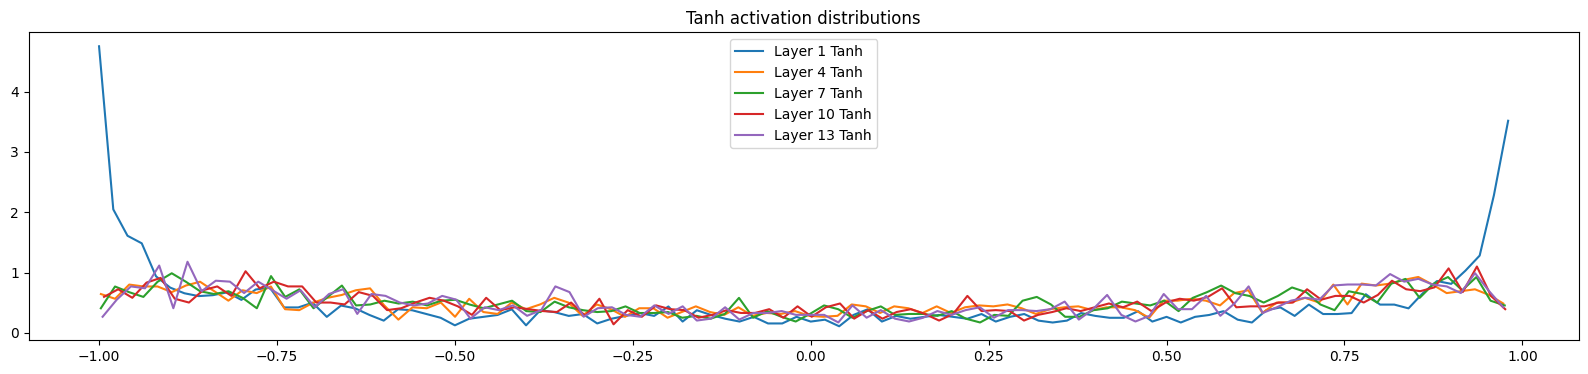

In [8]:
""" visiaalise the histograms for activations"""
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('Layer %d (%10s: mean %+.2f, std %.2f, saturated %.2f%%)' % (i, layer.__class__.__name__, t.mean().item(), t.std().item(), (t.abs()> 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Tanh activation distributions')

Layer 1: mean -0.000000, std 0.003469
Layer 4: mean -0.000000, std 0.003267
Layer 7: mean -0.000000, std 0.002930
Layer 10: mean -0.000000, std 0.002544
Layer 13: mean -0.000000, std 0.002479


'\nWant to mess with gain so that the gradient doesnt explode or \nvanish in forward or backward pass\n'

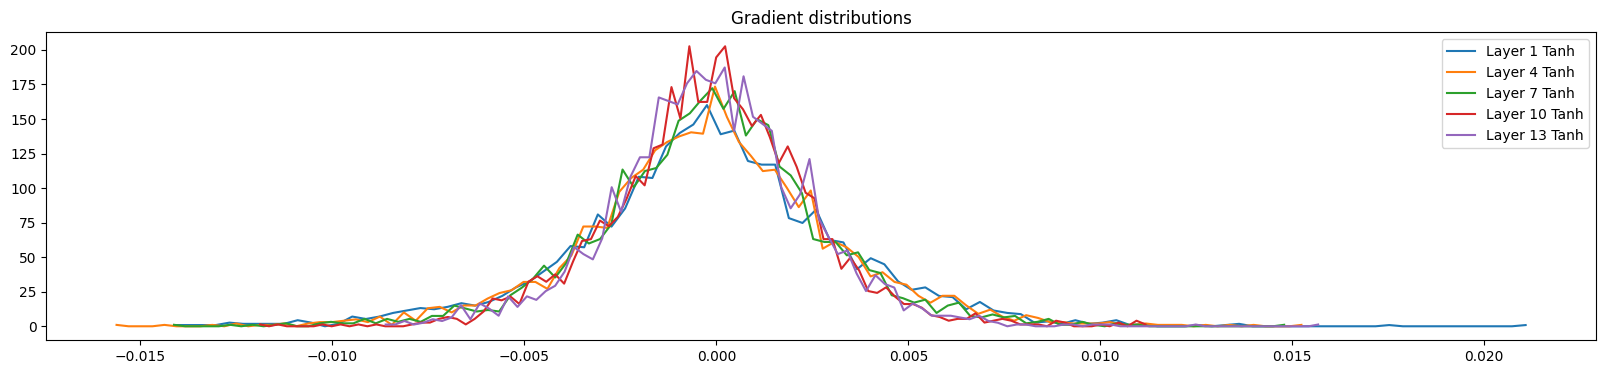

In [9]:
""" visiaalise the histograms for activations"""
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('Layer %d: mean %f, std %f' % (i, t.mean().item(), t.std().item()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Gradient distributions')
"""
Want to mess with gain so that the gradient doesnt explode or 
vanish in forward or backward pass
"""

Text(0.5, 1.0, 'Update to data ratio')

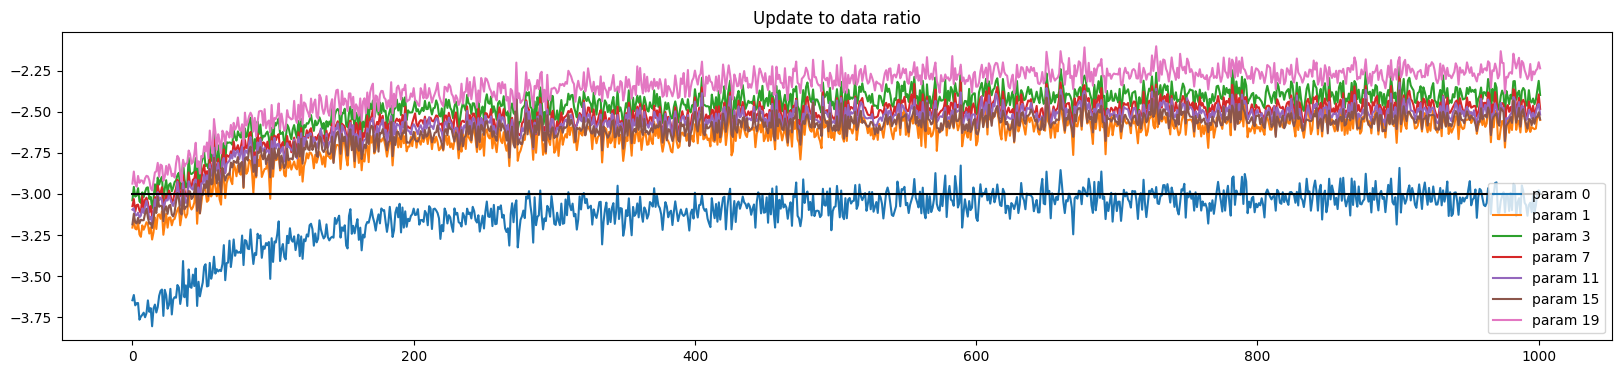

In [10]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.legend(legends)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.title('Update to data ratio')
# should be around 1e-3 (i.e. y=-3)